# Project Gutenberg Analysis

Explain why and how

In [7]:
import numpy as np
import pandas as pd
import zipfile
import sys
import os
import pickle
import gzip
from datetime import datetime
from metainfo import readmetadata
import matplotlib as plt


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.core import Activation
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, RNN
from keras.layers.embeddings import Embedding

In [2]:
DATA_ROOT = 'data'

In [3]:
time_start = datetime.now()
meta_data = readmetadata()
print('Read in ' + str(len(meta_data)) + ' books in ' + str(datetime.now() - time_start))
print(meta_data.shape)

Read in 56817 books in 0:00:00.192579
(56817, 8)


In [4]:
print(meta_data.columns)

Index(['id', 'author', 'title', 'downloads', 'LCC', 'subjects',
       'authoryearofbirth', 'authoryearofdeath'],
      dtype='object')


In [5]:
# Investigating Metadata
subs = meta_data['subjects'].str.len()
print(subs.value_counts().head())

1    22372
2    14272
3     7136
0     4660
4     3937
Name: subjects, dtype: int64


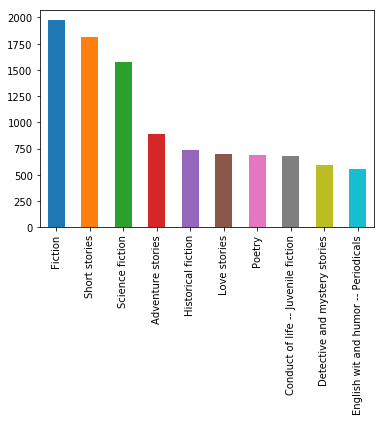

In [12]:
subject_list = list()
for subjects in meta_data['subjects']:
    for subject in subjects:
        subject_list.append(subject)
    
subject_list_series = pd.Series(subject_list)
subject_list_series.value_counts().head(10).plot(kind='bar')

In [58]:
meta_data_1 = meta_data.copy()
meta_data_2 = meta_data.copy()
meta_data_1 = meta_data_1[['subjects']].apply(lambda x: list(x))

mask = meta_data_1['subjects'].apply(
    lambda x: bool(set(x) & set(['Adventure stories', 'Poetry']))
)

meta_data_3 = meta_data_2[mask]
print(meta_data_3['subjects'].head(20))

121    {Napoleon I, Emperor of the French, 1769-1821 ...
148                                             {Poetry}
240                                             {Poetry}
311                                             {Poetry}
355                                             {Poetry}
364                                             {Poetry}
387    {Earth (Planet) -- Core -- Fiction, Voyages, I...
407                                             {Poetry}
408    {Fantasy fiction, Immortalism -- Fiction, Adve...
444    {Adventure stories, Voyages around the world -...
447    {Kidnapping -- Fiction, Adventure stories, Res...
507                                             {Poetry}
516    {Girls -- Juvenile fiction, Adventure stories,...
575                                             {Poetry}
620                                    {Ballads, Poetry}
643                          {Poetry, Prisons -- Poetry}
677                                             {Poetry}
766    {Tramps -- Fiction, Adve

        id                             author  \
121  10109  Marquand, John P. (John Phillips)   
148  10133              Quiller-Couch, Arthur   
240  10216                   Holley, Marietta   
311  10280              Dunbar, Paul Laurence   
355   1031                       Wilde, Oscar   

                                         title downloads   LCC  \
121                  The Unspeakable Gentleman        16  {PS}   
148  The Vigil of Venus and Other Poems by "Q"        23  {PR}   
240                                      Poems         6  {PS}   
311  In de Mornin' and Jes Gib Him One Ob Mine        12  {PS}   
355                 Charmides, and Other Poems        23  {PR}   

                                              subjects authoryearofbirth  \
121  {Napoleon I, Emperor of the French, 1769-1821 ...              1893   
148                                           {Poetry}              1863   
240                                           {Poetry}              1836   
311 

In [54]:
def get_book_text(book_id=None):    
    if not book_id:
#         print('Please pass in a book_id.')
        return
    file_path = os.path.join(DATA_ROOT, 'books', str(book_id) + '.zip')
    if not os.path.isfile(file_path):
#         print('File Does Not Exist')
        return
    
    with zipfile.ZipFile(file_path) as myzip:
        # Assuming we are after the only/first file
        with myzip.open(myzip.namelist()[0]) as myfile:
            # This could be done in one line but split for readability
            # Plus, this only needs to be run once per file and the results are then saved
            try:
                raw_data = myfile.read().decode('utf-8')
                # This removes the Project Gutenberg Header
                book_text = ''.join(raw_data.split('***')[2:])
                # Removes new lines
                book_text = book_text.replace('\n', ' ').replace('\r', ' ')
                return book_text
            except:
                return None
    return None

In [8]:
def get_all_books_text(meta_data):
    file_name = os.path.join(DATA_ROOT, 'books.text.pkl.gz')
    if os.path.isfile(file_name):
        return pickle.load(gzip.open(file_name, 'rb'))
    text = {}
    num_books = len(meta_data)
    start_time = datetime.now()
    for counter, book_id in enumerate(meta_data['id']):
        if counter % 1000 == 0:
            print('Processing book %s of %s in %s' % (counter, num_books, datetime.now() - start_time))
        book_text = get_book_text(book_id=book_id)
        if book_text:
            text[book_id] = book_text
    pickle.dump(text, gzip.open(file_name, 'wb'), protocol=-1)
    return text

In [29]:
time_start = datetime.now()
text = get_all_books_text(meta_data)
print('loaded ' + str(len(text)) + ' books in ' + str(datetime.now() - time_start))

loaded 930 books in 0:00:02.191003


In [17]:
# Checking our length
total_length = 0
for key in text:
    total_length += len(text[key])
print(total_length)

378296358


We want to convert our data from human-readable strings to machine-readable integers. In order to do that we will be using a tokenizer. This converts strings into arrays of numbers where the numbers correspond to the n-most common words and the rest of the words are 0s.

In [20]:
VOCAB_SIZE = 500

In [32]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(text.values())

In [34]:
def basic_lstm_model(embedding_vector_length=32, dropout_rate=0.2):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, embedding_vector_length, input_length=MAX_REVIEW_LEN))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(100))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model